In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import sys
from astropy.timeseries import LombScargle
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize_scalar
from scipy.signal import get_window

In [2]:
def LombScargle_period(times, rates, freqs):
    # Calculate the Lomb-Scargle periodogram of the light curve
    ls = LombScargle(times, rates)
    power = ls.power(freqs)

    # Find the frequency that gives the maximum power
    best_freq = freqs[np.argmax(power)]
    best_power = np.max(power)
    # Convert the frequency to a period
    best_period = 1. / best_freq

    # Return the H statistic and the best period
    return best_period, best_freq, best_power

In [3]:
def plot_histogram(phases, ylim_lower, bins, title):
    # Calculate the histogram of the phase-folded times
    hist, bin_edges = np.histogram(phases, bins=bins, range=(0, 2))

    # Calculate the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Now you can smooth the histogram data
    smoothed_hist = gaussian_filter1d(hist, 0.7)  # Change the second argument to adjust the amount of smoothing

    # Plot the histogram
    plt.figure(figsize=(6, 8))
    plt.bar(bin_centers, hist, width=1.0/bins, align='center', alpha=0.7, edgecolor='k')

    # Plot the smoothed data
    plt.plot(bin_centers, smoothed_hist, 'r-', linewidth=2)

    plt.ylim(ylim_lower, 1.005*np.max(hist))
    plt.xlabel('Phase')
    plt.ylabel('Counts')
    plt.title(title)
    plt.show()


In [4]:
def h_test(phases, num_harmonics=20):
    if len(phases) == 0:
        raise ValueError("Input array 'phases' is empty")
    if np.isnan(phases).any():
        raise ValueError("Input array 'phases' contains NaN values")

    m = np.arange(1, num_harmonics + 1)
    cos_terms = np.cos(2 * np.pi * m[:, None] * phases).sum(axis=1)
    sin_terms = np.sin(2 * np.pi * m[:, None] * phases).sum(axis=1)
    z_m_sq = 2 * len(phases) * (cos_terms**2 + sin_terms**2)
    h = np.max((m - 1) + z_m_sq)

    return h

def find_best_period(times, period_range, num_periods=10000):
    periods = np.linspace(period_range[0], period_range[1], num_periods)
    h_values = np.array([h_test((times / period) % 1) for period in periods])
    max_index = np.argmax(h_values)
    best_period_estimate = periods[max_index]

    # Further optimization for precise period determination
    upper_bound = period_range[1] if max_index == num_periods - 1 else periods[max_index + 1]
    result = minimize_scalar(lambda period: h_test((times / period) % 1), 
                             bounds=(periods[max_index-1], upper_bound), 
                             method='bounded', options={'xatol': 1e-7})

    plt.figure(figsize=(10, 5))
    plt.plot(periods, h_values, label='H-test values')
    plt.axvline(x=result.x, color='r', linestyle='--', label=f'Best Period: {result.x:.6f} s')
    plt.xlabel('Period (s)')
    plt.ylabel('H Statistic')
    plt.title('H-test Period Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()

    return result.x

In [5]:
def phase_fold(t, y, dy, period):
    # Calculate phases
    phases = t / period % 1

    # Duplicate phases, y, and dy for plotting over two periods
    phases = np.concatenate((phases, phases + 1))
    y = np.concatenate((y, y))
    dy = np.concatenate((dy, dy))

    # Sort by phase
    sort_i = np.argsort(phases)
    phases = phases[sort_i]
    y = y[sort_i]
    dy = dy[sort_i]
    # Return phase-folded data
    return phases, y, dy

### First of all, we load the data, in this case from 3 to 4 keV:

In [6]:
# Path to the 'data' directory
data_dir = './data/E3_4/'

# List all files in the 'data' directory
files = [f for f in os.listdir(data_dir) if f.endswith('corr_3_4.lc')]

print("FITS files found:", files)

# Initialize lists to store the time and rate arrays
time = []
rate = []
error = []
nMJDREFI = []
nMJDREFF = []
# Assuming 'files' is your list of FITS files from the 'data' folder
for file in files:
    file_path = os.path.join(data_dir, file)
    with fits.open(file_path) as hdul:
        # Print the header of the first HDU as before
        print(hdul[0].header)
        # Append the observation time and rate arrays to the lists
        time.append(hdul[1].data['TIME'])
        rate.append(hdul[1].data['RATE'])
        error.append(hdul[1].data['ERROR'])
        nMJDREFI.append(hdul[0].header['MJDREFI'])
        nMJDREFF.append(hdul[0].header['MJDREFF'])

# Flatten the list of rates
all_rates = np.concatenate(rate)

# Flatten the lsit of times
all_times = np.concatenate(time)

# Flatten the list of errors
all_errors = np.concatenate(error)

# Select the phase-folded times that correspond to the selected rates
selected_rates = all_rates[all_rates > 0.00001]

# Select the phase-folded times that correspond to the selected rates
selected_times = all_times[all_rates > 0.00001]

# Select the phase-folded errors that correspond to the selected rates
selected_errors = all_errors[all_rates > 0.00001]

FITS files found: ['nu2A01_corr_3_4.lc', 'nu2B01_corr_3_4.lc', 'nu3A01_corr_3_4.lc', 'nu3B01_corr_3_4.lc', 'nu5A01_corr_3_4.lc', 'nu5B01_corr_3_4.lc', 'nu7A01_corr_3_4.lc', 'nu7B01_corr_3_4.lc']
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H TELESCOP= 'NuSTAR  '           / Telescope (mission) name                       DATAMODE= 'NONE    '           / Datamode                                       DETNAM  = 'NONE    '           / Detector                                       INSTRUME= 'FPMA    '           / Instrument name                                OBJEC

# Pulse profile

Now, we are going to guess the period using the h-test function defined before. 

 ## 1. First observation from 3-4 keV

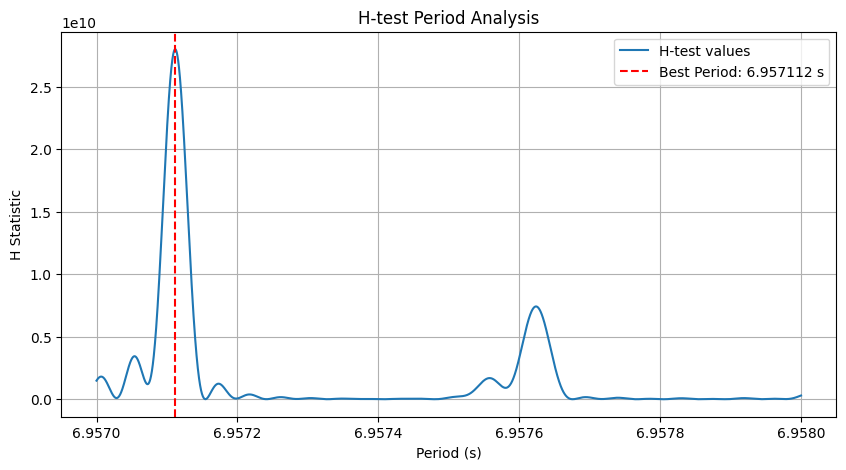

The best period is 6.957112 seconds


In [7]:
# Range of periods to test
period_range = (6.957, 6.958)
best_period = find_best_period(time[0], period_range)
print(f"The best period is {best_period:.6f} seconds")

In [8]:

# Create a window function
#window = get_window('hann', len(time[i]))

# Apply the window function to the rate
#rate_windowed = rate[i] * window

# Call the function with your data
phases, y_folded, dy_folded = phase_fold(time[0], rate[0], error[0], period=best_period) # 6.957298181371899

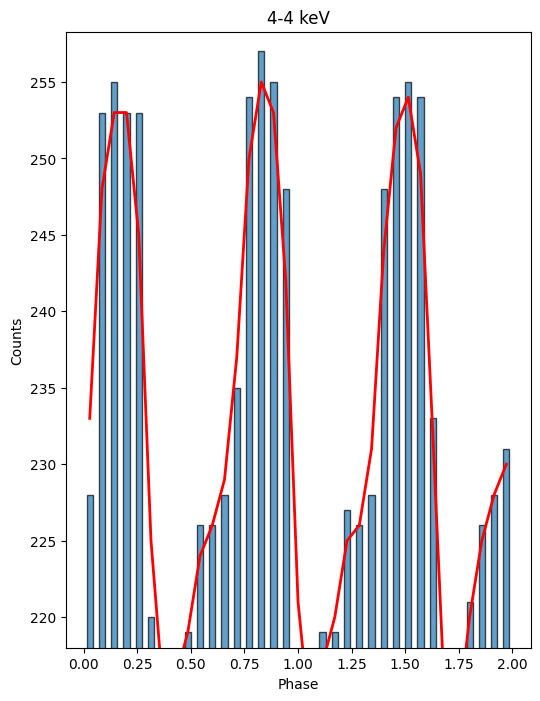

In [9]:
plot_histogram(phases, 218, 35, '4-4 keV')

 ## 2. Second observation from 3-4 keV

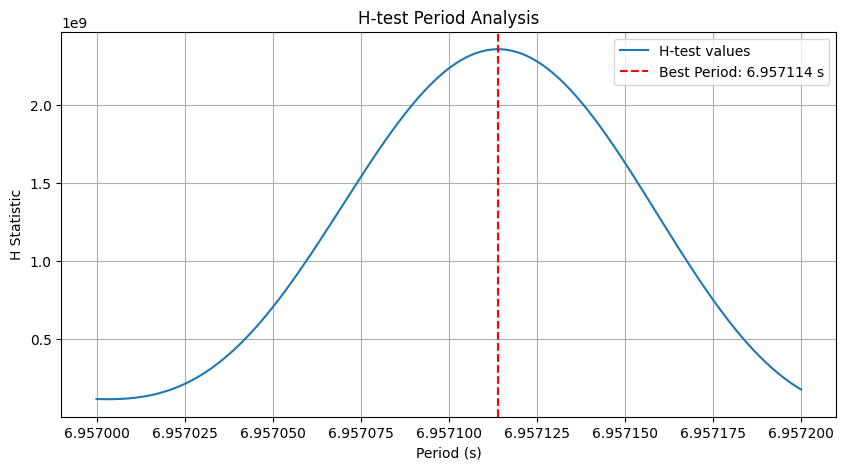

The best period is 6.957114 seconds


In [10]:
# Range of periods to test
period_range = (6.957, 6.9572)
best_period = find_best_period(time[2], period_range)
print(f"The best period is {best_period:.6f} seconds")

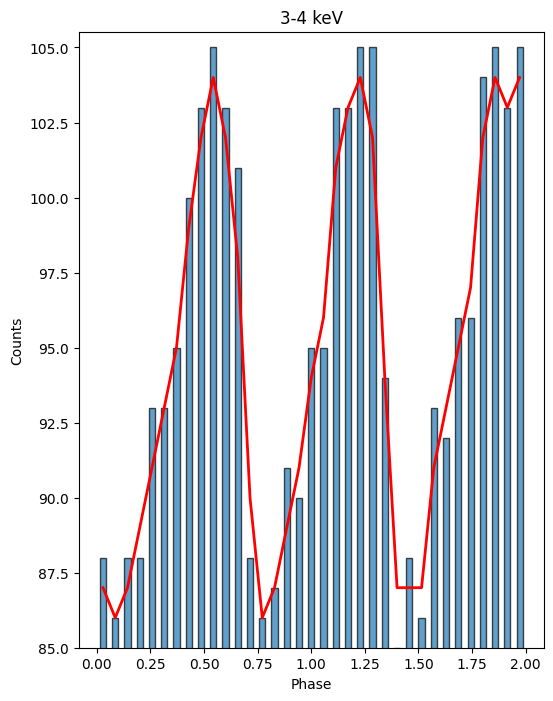

In [11]:
# Phase folds the data
phases, y_folded, dy_folded = phase_fold(time[2], rate[2], error[2], period=best_period) # 6.957298181371899
# Plots the pulse profile
plot_histogram(phases, 85, 35, '3-4 keV')

 ## 3. Third observation from 3-4 keV

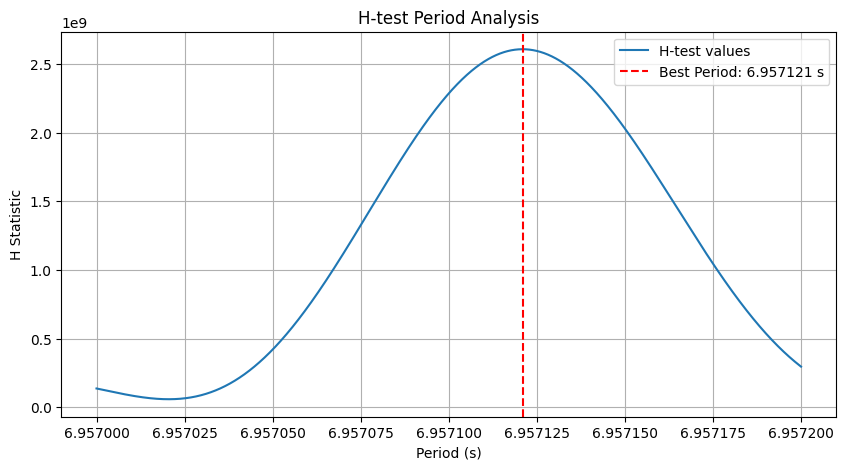

The best period is 6.957121 seconds


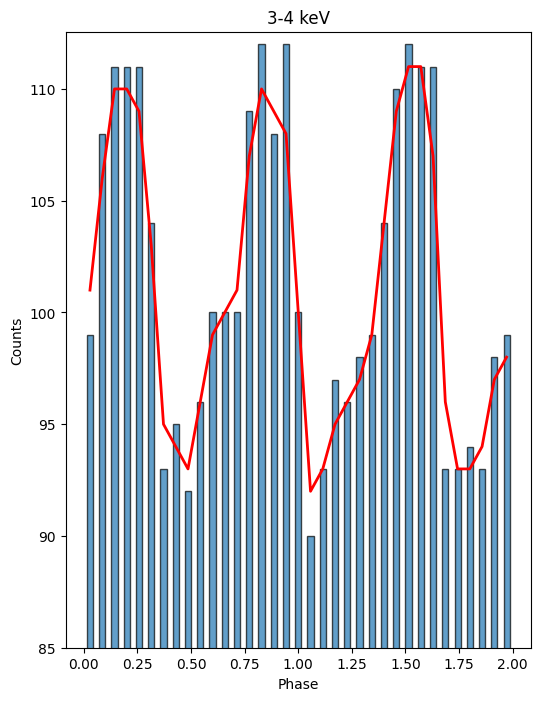

In [14]:
# Range of periods to test
period_range = (6.957, 6.9572)
best_period = find_best_period(time[4], period_range)
print(f"The best period is {best_period:.6f} seconds")

# Phase folds the data
phases, y_folded, dy_folded = phase_fold(time[4], rate[4], error[4], period=best_period) # 6.957298181371899
# Plots the pulse profile
plot_histogram(phases, 85, 35, '3-4 keV')

 ## 4. Fourth observation from 3-4 keV

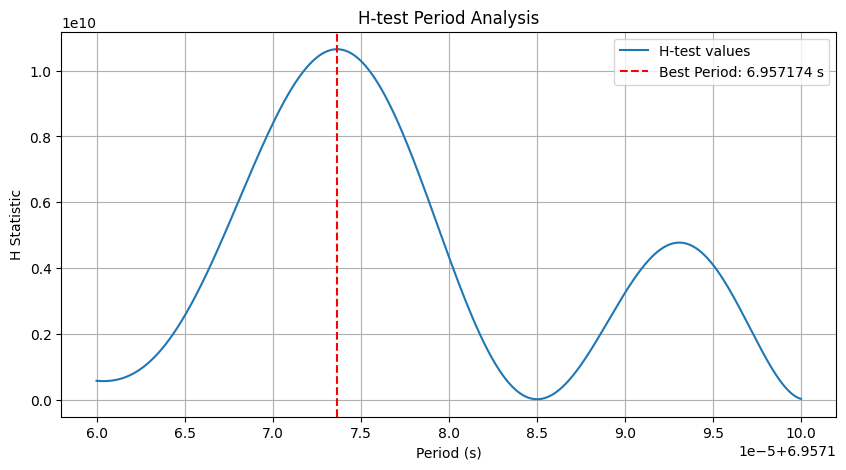

The best period is 6.957174 seconds


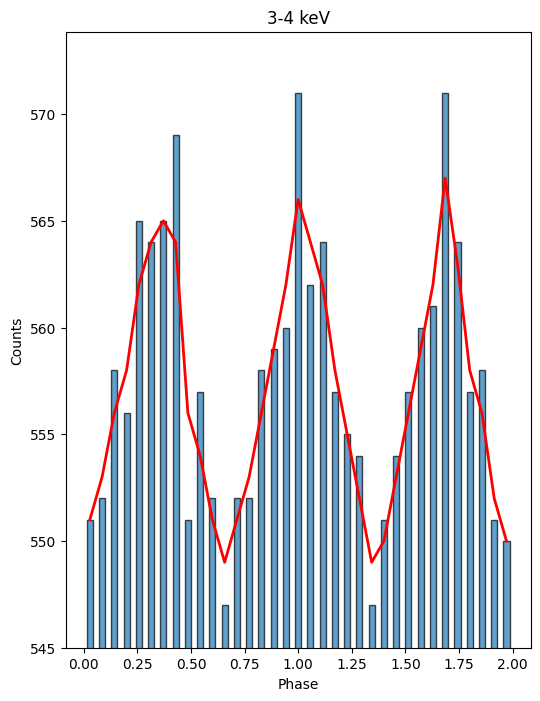

In [15]:
# Range of periods to test
period_range = (6.95716, 6.9572)
best_period = find_best_period(time[6], period_range)
print(f"The best period is {best_period:.6f} seconds")

# Phase folds the data
phases, y_folded, dy_folded = phase_fold(time[6], rate[6], error[6], period=best_period) # 6.957298181371899
# Plots the pulse profile
plot_histogram(phases, 545, 35,'3-4 keV')

# 11-16 keV

In [16]:
# Path to the 'data' directory
data_dir = './data/E11_16/'

# List all files in the 'data' directory
files = [f for f in os.listdir(data_dir) if f.endswith('corr_11_16.lc')]

print("FITS files found:", files)

# Initialize lists to store the time and rate arrays
time = []
rate = []
error = []
nMJDREFI = []
nMJDREFF = []
# Assuming 'files' is your list of FITS files from the 'data' folder
for file in files:
    file_path = os.path.join(data_dir, file)
    with fits.open(file_path) as hdul:
        # Print the header of the first HDU as before
        print(hdul[0].header)
        # Append the observation time and rate arrays to the lists
        time.append(hdul[1].data['TIME'])
        rate.append(hdul[1].data['RATE'])
        error.append(hdul[1].data['ERROR'])
        nMJDREFI.append(hdul[0].header['MJDREFI'])
        nMJDREFF.append(hdul[0].header['MJDREFF'])

# Flatten the list of rates
all_rates = np.concatenate(rate)

# Flatten the lsit of times
all_times = np.concatenate(time)

# Flatten the list of errors
all_errors = np.concatenate(error)

# Select the phase-folded times that correspond to the selected rates
selected_rates = all_rates[all_rates > 0.00001]

# Select the phase-folded times that correspond to the selected rates
selected_times = all_times[all_rates > 0.00001]

# Select the phase-folded errors that correspond to the selected rates
selected_errors = all_errors[all_rates > 0.00001]

FITS files found: ['nu2A01_corr_11_16.lc', 'nu3B01_corr_11_16.lc', 'nu5A01_corr_11_16.lc', 'nu5B01_corr_11_16.lc', 'nu7A01_corr_11_16.lc', 'nu7B01_corr_11_16.lc']
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H TELESCOP= 'NuSTAR  '           / Telescope (mission) name                       DATAMODE= 'NONE    '           / Datamode                                       DETNAM  = 'NONE    '           / Detector                                       INSTRUME= 'FPMA    '           / Instrument name                                OBJECT  = '1E2259p586'         / Name

 ### 1. First observation 11-16 keV

Let's use the same period raneg as for the case 3-4 keV

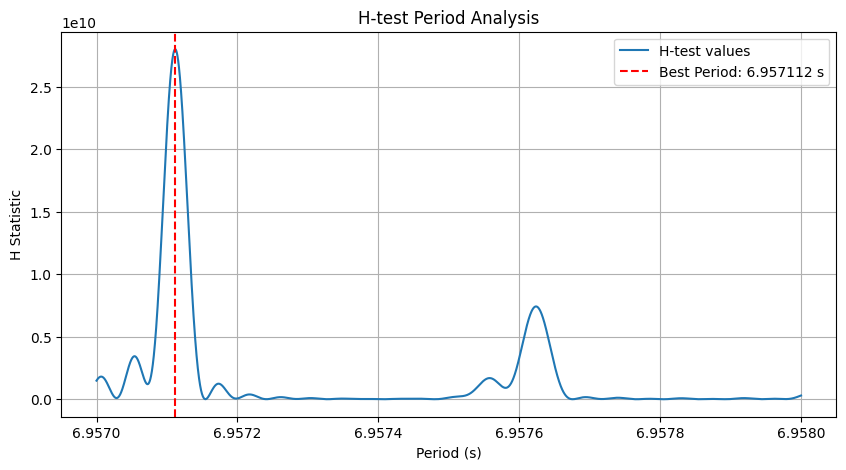

The best period is 6.957112 seconds


In [17]:
# Range of periods to test
period_range = (6.9570,6.9580)
best_period = find_best_period(time[0], period_range)
print(f"The best period is {best_period:.6f} seconds")

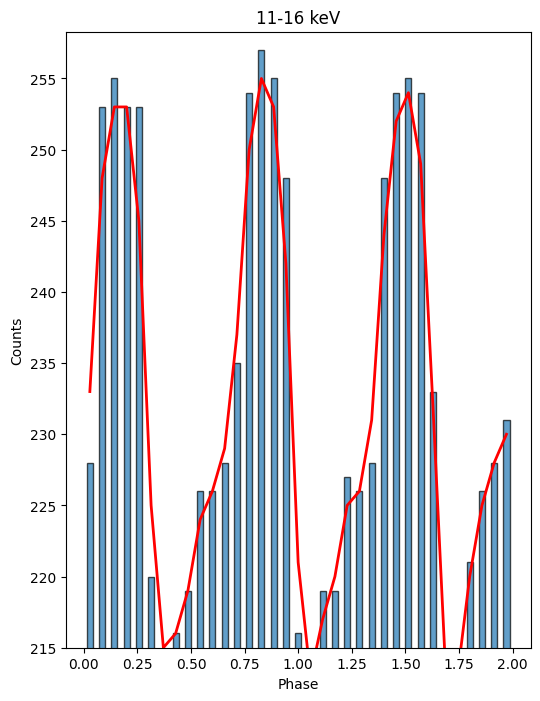

In [30]:
# Phase folds the data
phases, y_folded, dy_folded = phase_fold(time[0], rate[0], error[0], period=best_period) # 6.957298181371899
# Plots the pulse profile
plot_histogram(phases, 215, 35, '11-16 keV')

 ### 2. Second observation 16-24 keV

--------------------------------------------------------------------------------------------------

### Period Derivative

In [ ]:
# Calculate best periods, frequencies, and powers using list comprehension
# Define the range of frequencies to test
f_n_steps = 100000
f_init = 0.14
f_final = 0.15
frequencies = np.linspace(f_init, f_final, f_n_steps)  # Define your frequency search range

best_periods, best_freqs, best_powers = zip(*[LombScargle_period(t, r, frequencies) for t, r in zip(time, rate)])

# Convert to numpy arrays
best_periods = np.array(best_periods)
best_freqs = np.array(best_freqs)
best_powers = np.array(best_powers)

# Calculate average times
avg_times = np.array([np.mean(t) for t in time])

# Fit a line to the periods versus average times
slope, intercept = np.polyfit(avg_times, best_periods, 1)

# The slope of the line is the period derivative
period_derivative = slope

print("Period derivative:", period_derivative)

# Calculate average period
avg_period = np.mean(best_periods)

# Calculate frequency derivative
freq_derivative = -period_derivative / (avg_period**2)

print("Frequency derivative:", freq_derivative)